In [0]:
from datetime import datetime
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import set_option
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.models import load_model,Model
from keras.layers import Input,Dense,Activation,BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, TensorBoard
import keras.backend as K


from keras import regularizers
import tensorflow as tf

from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
# from sklearn.metrics import precision_recall_fscore_support
# from ml4jets_util import f1_score
from pprint import pprint

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Importing Dataset and Pre-processing

In [0]:
path = 'drive/My Drive//Colab Notebooks//datasets//jets//'


df_train = pd.read_csv(path+'train_export_jets.csv',delimiter=',')
df_test = pd.read_csv(path+'test_export_jets.csv',delimiter=',')
df_validation = pd.read_csv(path+'val_export_jets.csv',delimiter=',')

df_train.drop(labels=['Unnamed: 0'],axis=1,inplace=True)
df_test.drop(labels=['Unnamed: 0'],axis=1,inplace=True)
df_validation.drop(labels=['Unnamed: 0'],axis=1,inplace=True)

In [0]:
df_test.shape

(3300, 62)

In [0]:
X_train = df_train.drop(labels=['class','njets'],axis=1)
X_test = df_test.drop(labels=['class','njets'],axis=1)
X_val = df_validation.drop(labels=['class','njets'],axis=1)


y_train = df_train['class'].astype(int).values
y_test = df_test['class'].astype(int).values
y_val = df_validation['class'].astype(int).values

In [0]:
scaler = StandardScaler().fit(X_train)

X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

### Configuring AE

In [0]:
def build_simple_autoencoder():
  encoding_dim = 60
  hidden_dim = int(encoding_dim / 2)
  learning_rate = 1e-3

  input_layer = Input(shape=(input_dim, ))

  #encoder
  encoder = Dense(encoding_dim)(input_layer)
  encoder = BatchNormalization()(encoder)
  encoder = Activation(activation='relu')(encoder)

  encoder = Dense(hidden_dim)(encoder)
  encoder = BatchNormalization()(encoder)
  encoder = Activation(activation='relu')(encoder)

  encoder = Dense(int(hidden_dim/2))(encoder)
  encoder = BatchNormalization()(encoder)
  encoder = Activation(activation='relu')(encoder)

  #decoder
  decoder = Dense(hidden_dim)(encoder)
  decoder = BatchNormalization()(decoder)
  decoder = Activation(activation='relu')(decoder)

  decoder = Dense(encoding_dim)(decoder)
  decoder = BatchNormalization()(decoder)
  decoder = Activation(activation='relu')(decoder)

  decoder = Dense(input_dim)(decoder)
  decoder = BatchNormalization()(decoder)
  decoder = Activation(activation='tanh')(decoder)

  autoencoder = Model(inputs=input_layer, outputs=decoder)
  autoencoder.summary()
  return autoencoder

In [0]:
nb_epoch = 500
batch_size = 32
input_dim = X_train_norm.shape[1]
autoencoder = build_simple_autoencoder()
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 60)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 60)                3660      
_________________________________________________________________
batch_normalization_13 (Batc (None, 60)                240       
_________________________________________________________________
activation_13 (Activation)   (None, 60)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 30)                1830      
_________________________________________________________________
batch_normalization_14 (Batc (None, 30)                120       
_________________________________________________________________
activation_14 (Activation)   (None, 30)                0   

In [0]:
cp = ModelCheckpoint(filepath="autoencoder_classifier_reconstruction.h5",
                               save_best_only=True,
                               verbose=0)

earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'auto')
start_time = time.time()
print('Starting Training for AutoEncoder...')
history = autoencoder.fit(X_train_norm, X_train_norm,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_val_norm, X_val_norm),
                    verbose=0,
                    callbacks=[cp,earlyStopping]).history
print('Total elapsed time:' ,(time.time() - start_time), 'seconds')

Starting Training for AutoEncoder...
Total elapsed time: 89.5932207107544 seconds


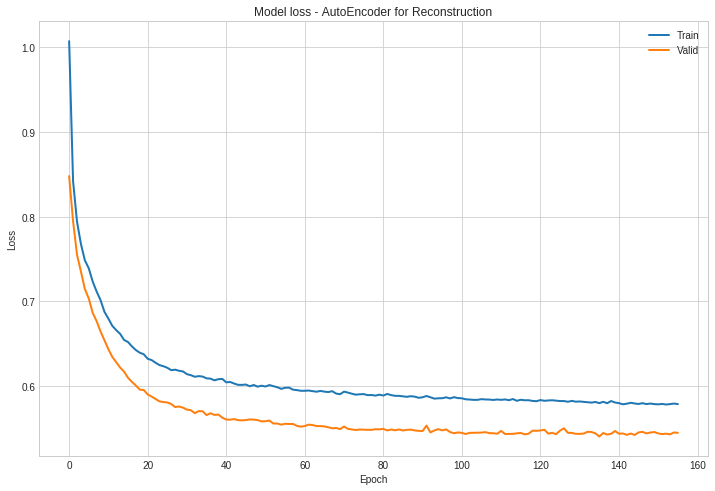

In [0]:
plt.style.use('seaborn-whitegrid')  
plt.figure(figsize=(12, 8))
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss - AutoEncoder for Reconstruction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.savefig('Model_loss_AutoEncoder_reconstruction.png')
plt.show()

### Mounting AE with simple MLP

In [0]:
encoder1layer = autoencoder.get_layer(index=1)
encoder2layer = autoencoder.get_layer(index=2)
encoder3layer =  autoencoder.get_layer(index=3)

encoder1layer.trainable = False
encoder2layer.trainable = False
encoder3layer.trainable = False


Stack_AE_MLP = Sequential(name='Stack_AE_MLP')
Stack_AE_MLP.add(encoder1layer)
Stack_AE_MLP.add(encoder2layer)
Stack_AE_MLP.add(encoder3layer)


Stack_AE_MLP.add(Sequential([ 
  Dense(15),
  BatchNormalization(),
  Activation('relu'),
  Dense(7),
  BatchNormalization(),
  Activation('relu'),
  Dense(1, activation='linear')
  ]))

In [0]:
nb_epoch = 500
batch_size = 32
learning_rate = 1e-3


Stack_AE_MLP.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
                    

In [0]:
cp = ModelCheckpoint(filepath="Stack_AE_MLP.h5",
                               save_best_only=True,
                               verbose=0)

earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'auto')
start_time = time.time()
print('Starting Training for AutoEncoder...')
history_mlp = Stack_AE_MLP.fit(X_train_norm, y_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_val_norm, y_val),
                    verbose=0,
                    callbacks=[cp,earlyStopping]).history
print('Total elapsed time:' ,(time.time() - start_time), 'seconds')

Starting Training for AutoEncoder...
Total elapsed time: 25.841152906417847 seconds


In [0]:
Stack_AE_MLP.summary()

Model: "Stack_AE_MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 60)                3660      
_________________________________________________________________
batch_normalization_13 (Batc (None, 60)                240       
_________________________________________________________________
activation_13 (Activation)   (None, 60)                0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 1123      
Total params: 5,023
Trainable params: 1,079
Non-trainable params: 3,944
_________________________________________________________________


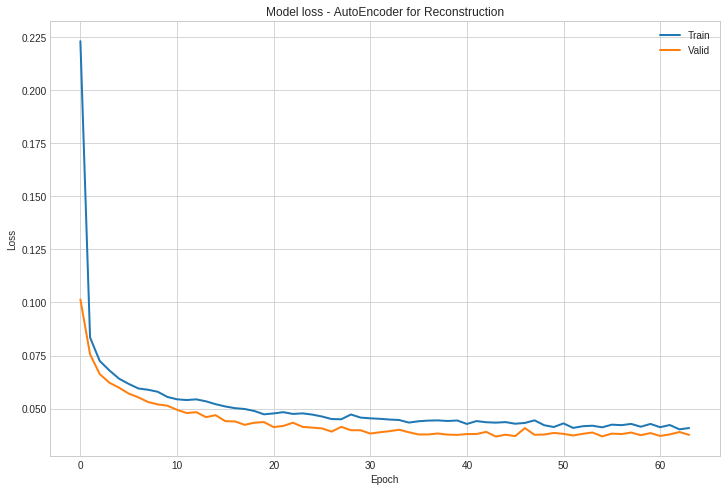

In [0]:
plt.style.use('seaborn-whitegrid')  
plt.figure(figsize=(12, 8))
plt.plot(history_mlp['loss'], linewidth=2, label='Train')
plt.plot(history_mlp['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss - AutoEncoder for Reconstruction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.savefig('Model_loss_AutoEncoder_reconstruction.png')
plt.show()

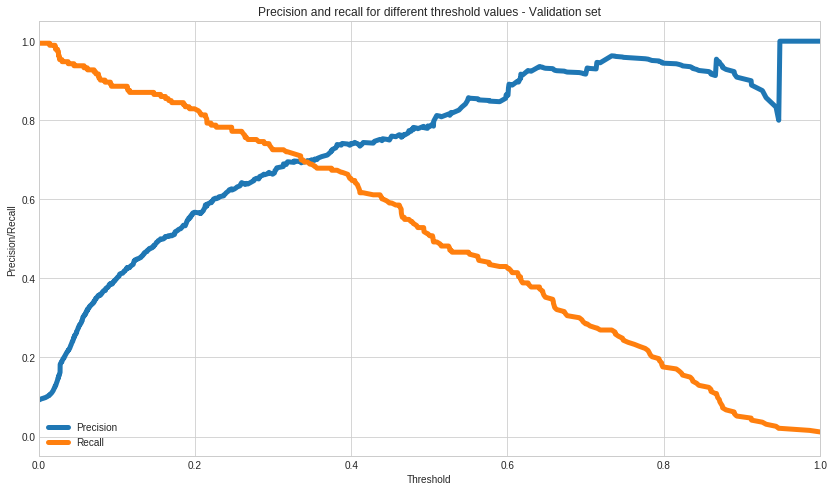

In [0]:
y_val_pred = Stack_AE_MLP.predict(X_val_norm)
precision_rt, recall_rt, threshold_rt = precision_recall_curve(y_val, y_val_pred)

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(14,8))
plt.plot(threshold_rt[:], precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt[:], recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values - Validation set')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.xlim(0,1)
plt.grid(True)
plt.savefig('Precision_Recall_AutoEncoder_reconstruction.png')

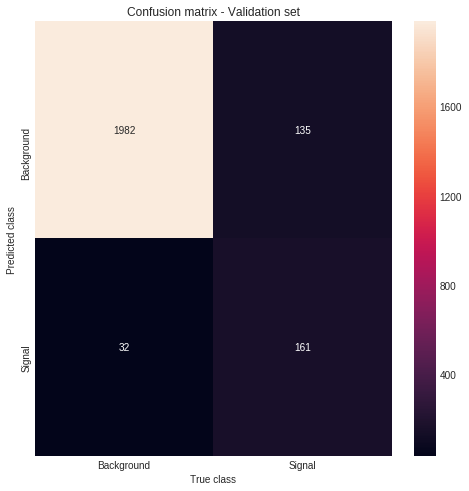

              precision    recall  f1-score   support

  Background       0.98      0.94      0.96      2117
      Signal       0.54      0.83      0.66       193

    accuracy                           0.93      2310
   macro avg       0.76      0.89      0.81      2310
weighted avg       0.95      0.93      0.93      2310



In [0]:
threshold = 0.19
y_val_pred[y_val_pred <= threshold] = 0
y_val_pred[y_val_pred > threshold] = 1

df_prediction = pd.DataFrame({'Predicted': y_val_pred.ravel(),
                        'True_class': y_val.ravel()})

LABELS = ["Background","Signal"]
conf_matrix = confusion_matrix(df_prediction.True_class, df_prediction.Predicted)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix - Validation set")
plt.xlabel('True class')
plt.ylabel('Predicted class')
plt.show()

target_names = ["Background","Signal"]
c = classification_report(df_prediction.True_class, df_prediction.Predicted,target_names =target_names)
print(c)

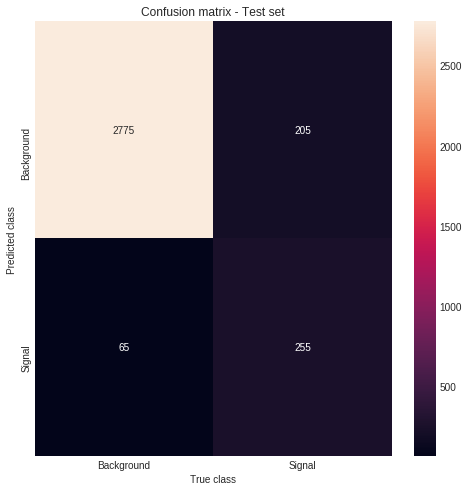

              precision    recall  f1-score   support

  Background       0.98      0.93      0.95      2980
      Signal       0.55      0.80      0.65       320

    accuracy                           0.92      3300
   macro avg       0.77      0.86      0.80      3300
weighted avg       0.94      0.92      0.92      3300



In [0]:
y_test_pred = Stack_AE_MLP.predict(X_test_norm)
y_test_pred[y_test_pred <= threshold] = 0
y_test_pred[y_test_pred > threshold] = 1

df_prediction = pd.DataFrame({'Predicted': y_test_pred.ravel(),
                        'True_class': y_test.ravel()})

LABELS = ["Background","Signal"]
conf_matrix = confusion_matrix(df_prediction.True_class, df_prediction.Predicted)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix - Test set")
plt.xlabel('True class')
plt.ylabel('Predicted class')
plt.show()

target_names = ["Background","Signal"]
c = classification_report(df_prediction.True_class, df_prediction.Predicted,target_names =target_names)
print(c)

### Results with PCA and MLP

In [0]:
pca = PCA(n_components=15, svd_solver='full')

In [0]:
pca.fit(X_train_norm)
X_train_PCA_norm = pca.fit_transform(X_train_norm)
X_val_PCA_norm = pca.fit_transform(X_val_norm)
X_test_PCA_norm = pca.fit_transform(X_test_norm)


In [0]:
nb_epoch = 500
batch_size = 32
input_dim = X_train_PCA_norm.shape[1]
learning_rate = 1e-3


MLP_PCA = Sequential([ ])
MLP_PCA.add(Sequential([ 
  Dense(15, activation='relu'),
  Dense(7, activation='relu'),
  Dense(1, activation='linear')
  ]))
MLP_PCA.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="MLP_PCA.h5",
                               save_best_only=True,
                               verbose=0)

earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 30, mode = 'auto')
start_time = time.time()
print('Starting Training for AutoEncoder...')
history_PCA = MLP_PCA.fit(X_train_PCA_norm, y_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_val_PCA_norm, y_val),
                    verbose=0,
                    callbacks=[cp,earlyStopping]).history
print('Total elapsed time:' ,(time.time() - start_time), 'seconds')

Starting Training for AutoEncoder...
Total elapsed time: 14.356121063232422 seconds


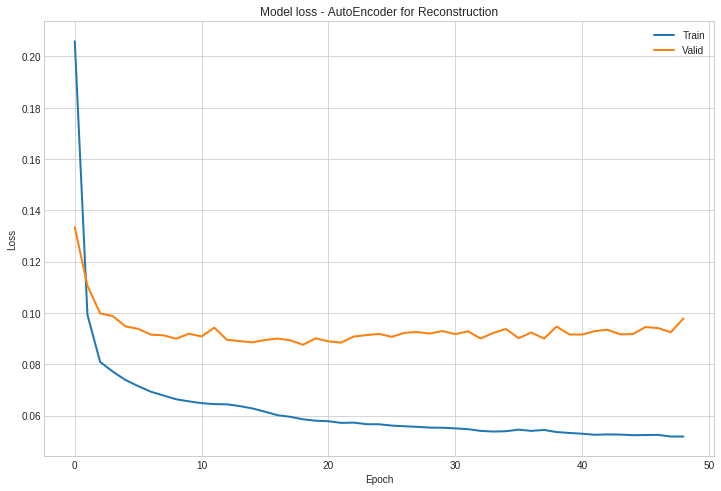

In [0]:
plt.style.use('seaborn-whitegrid')  
plt.figure(figsize=(12, 8))
plt.plot(history_PCA['loss'], linewidth=2, label='Train')
plt.plot(history_PCA['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss - AutoEncoder for Reconstruction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.savefig('Model_loss_AutoEncoder_reconstruction.png')
plt.show()

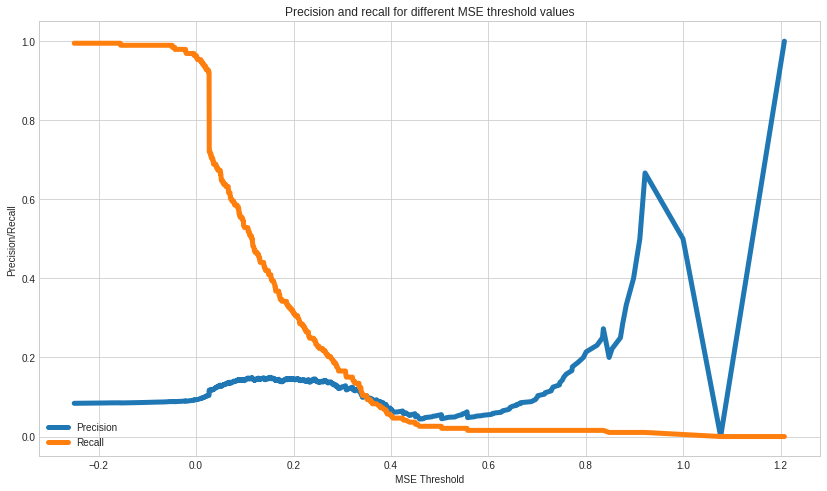

In [0]:
y_predictions = MLP_PCA.predict(X_val_PCA_norm)
precision_rt, recall_rt, threshold_rt = precision_recall_curve(y_val, y_predictions)

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(14,8))
plt.plot(threshold_rt[:], precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt[:], recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different MSE threshold values')
plt.xlabel('MSE Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
# plt.xlim(0,0.5)
plt.grid(True)
plt.savefig('Precision_Recall_AutoEncoder_reconstruction.png')

In [0]:

threshold = 0.1
def mse(real,prediction):
  return np.mean(((real - prediction)**2), axis=1)
  
y_test_pred = MLP_PCA.predict(X_test_PCA_norm)
y_test_pred[y_test_pred < threshold] = 0
y_test_pred[y_test_pred > threshold] = 1

df_prediction = pd.DataFrame({'Predicted': y_test_pred.ravel(),
                        'True_class': y_test.ravel()})

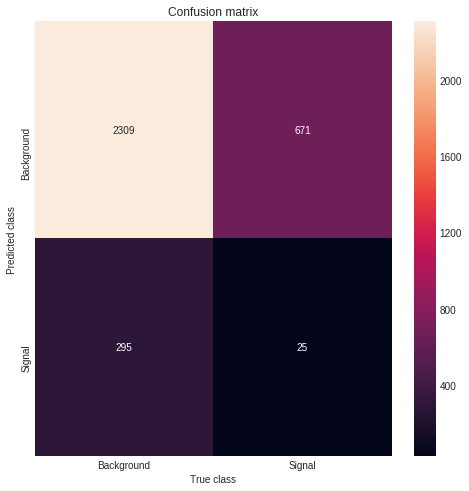

In [0]:
LABELS = ["Background","Signal"]
conf_matrix = confusion_matrix(df_prediction.True_class, df_prediction.Predicted)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.xlabel('True class')
plt.ylabel('Predicted class')
plt.show()



In [0]:
target_names = ["Background","Signal"]
c = classification_report(df_prediction.True_class, df_prediction.Predicted,target_names =target_names)
print(c)

              precision    recall  f1-score   support

  Background       0.89      0.77      0.83      2980
      Signal       0.04      0.08      0.05       320

    accuracy                           0.71      3300
   macro avg       0.46      0.43      0.44      3300
weighted avg       0.80      0.71      0.75      3300



### Deep MLP

In [0]:
def build_deep_mlp():
  first_layer = 60
  second = int(first_layer / 2)
  learning_rate = 1e-3

  input_layer = Input(shape=(input_dim, ))

  #encoder
  mlp = Dense(first_layer)(input_layer)
  mlp = BatchNormalization()(mlp)
  mlp = Activation(activation='relu')(mlp)

  mlp = Dense(second)(mlp)
  mlp = BatchNormalization()(mlp)
  mlp = Activation(activation='relu')(mlp)

  mlp = Dense(int(second/2))(mlp)
  mlp = BatchNormalization()(mlp)
  mlp = Activation(activation='relu')(mlp)

  mlp = Dense(int(second/4))(mlp)
  mlp = BatchNormalization()(mlp)
  mlp = Activation(activation='relu')(mlp)

  mlp = Dense(1)(mlp)
  mlp = BatchNormalization()(mlp)
  mlp = Activation(activation='linear')(mlp)
  mlp = Model(inputs=input_layer, outputs=mlp)
  mlp.summary()
  return mlp

In [0]:
nb_epoch = 500
batch_size = 32
learning_rate = 1e-3
input_dim = 60
deep_mlp = build_deep_mlp()
deep_mlp.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 60)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 60)                3660      
_________________________________________________________________
batch_normalization_31 (Batc (None, 60)                240       
_________________________________________________________________
activation_31 (Activation)   (None, 60)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 30)                1830      
_________________________________________________________________
batch_normalization_32 (Batc (None, 30)                120       
_________________________________________________________________
activation_32 (Activation)   (None, 30)                0   

In [0]:
cp = ModelCheckpoint(filepath="deep_mlp.h5",
                               save_best_only=True,
                               verbose=0)

earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'auto')
start_time = time.time()
print('Starting Training for AutoEncoder...')
history_mlp = deep_mlp.fit(X_train_norm, y_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_val_norm, y_val),
                    verbose=0,
                    callbacks=[cp,earlyStopping]).history
print('Total elapsed time:' ,(time.time() - start_time), 'seconds')

Starting Training for AutoEncoder...
Total elapsed time: 44.85361361503601 seconds


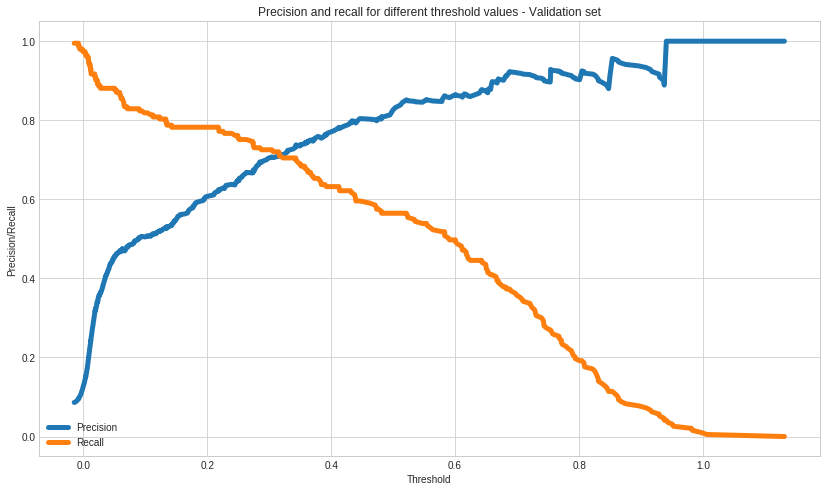

In [0]:
y_val_pred = deep_mlp.predict(X_val_norm)
precision_rt, recall_rt, threshold_rt = precision_recall_curve(y_val, y_val_pred)

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(14,8))
plt.plot(threshold_rt[:], precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt[:], recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values - Validation set')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
# plt.xlim(0,1)
plt.grid(True)
plt.savefig('Precision_Recall_AutoEncoder_reconstruction.png')

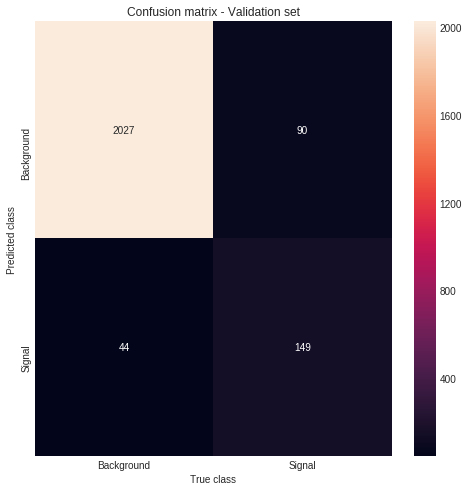

              precision    recall  f1-score   support

  Background       0.98      0.96      0.97      2117
      Signal       0.62      0.77      0.69       193

    accuracy                           0.94      2310
   macro avg       0.80      0.86      0.83      2310
weighted avg       0.95      0.94      0.94      2310



In [0]:
threshold = 0.22
y_val_pred[y_val_pred <= threshold] = 0
y_val_pred[y_val_pred > threshold] = 1

df_prediction = pd.DataFrame({'Predicted': y_val_pred.ravel(),
                        'True_class': y_val.ravel()})

LABELS = ["Background","Signal"]
conf_matrix = confusion_matrix(df_prediction.True_class, df_prediction.Predicted)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix - Validation set")
plt.xlabel('True class')
plt.ylabel('Predicted class')
plt.show()

target_names = ["Background","Signal"]
c = classification_report(df_prediction.True_class, df_prediction.Predicted,target_names =target_names)
print(c)

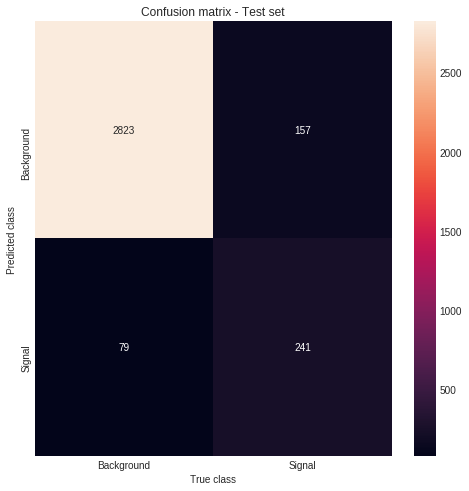

              precision    recall  f1-score   support

  Background       0.97      0.95      0.96      2980
      Signal       0.61      0.75      0.67       320

    accuracy                           0.93      3300
   macro avg       0.79      0.85      0.82      3300
weighted avg       0.94      0.93      0.93      3300



In [0]:
y_test_pred = deep_mlp.predict(X_test_norm)
y_test_pred[y_test_pred <= threshold] = 0
y_test_pred[y_test_pred > threshold] = 1

df_prediction = pd.DataFrame({'Predicted': y_test_pred.ravel(),
                        'True_class': y_test.ravel()})

LABELS = ["Background","Signal"]
conf_matrix = confusion_matrix(df_prediction.True_class, df_prediction.Predicted)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix - Test set")
plt.xlabel('True class')
plt.ylabel('Predicted class')
plt.show()

target_names = ["Background","Signal"]
c = classification_report(df_prediction.True_class, df_prediction.Predicted,target_names =target_names)
print(c)